# **Exploring Metis Data within the Sunpy ecosystem**

*Welcome to this hands-on tutorial on the **Metis coronagraph**  aboard the **ESA Solar Orbiter** mission.*


---

This tutorial is aimed to show a complete, reproducible workflow for analyzing Metis data in Python and the SunPy ecosystem:
**data discovery -> inspection -> visualisation -> preparation -> multi-instrument composite image**

### What you will learn in this notebook:
In this tutorial you will learn how to:
1.   Query and download **Metis Level-2** products from [SOAR](https://soar.esac.esa.int/soar/#search) using `sunpy.net.Fido`.
2. **Load and visualise** Metis  L2 data (VL and UV images) as Sunpy maps.
3. **Apply basic pre-processing and masking techniques** (occulter masking and contrast scaling)
4. Build a **Metis–EUI composite image** as a first example of joint, multi-instrument analysis.

These steps form the foundation for more advanced investigations, including radial brightness profiles, polar-coordinate projections, time-dependent studies and cross-instrument co-alignment.

> *The examples are designed for Colab/Jupyter/Binder and use only public SOAR data.*




---



## **Instrument Overview: The Metis Coronagraph**
[Metis](https://metis.oato.inaf.it/instrument.html) is a multi-wavelength coronagraph designed to study the solar corona **simultaneously in two channels**:

                                 
- **Visible Light (VL, 580–640 nm)**

  Measures polarized/total white-light emission (K-corona) produced by Thomson scattering of photospheric photons by free coronal electrons.
- **Ultraviolet (UV, 121.6 nm)**

  Detects the narrowband monochromatic **HI Lyman-α** emission from neutral hydrogen atoms in the extended corona.  
  *Note: The same spectral line is observed on-disk by the EUI/HRILYA, also onboard Solar Orbiter, enabling coordinated disk–corona studies.*

Metis covers approximately **1.7-10 solar radii** (depending on the spacecraft heliocentric distance).




**L2 Metis product identifiers**

- *metis-vl-pb* - Polarized Brightness (pB)
- *metis-vl-image* - Visible Light images
- *metis-vl-pol-angle* - Polarization Angle
- *metis-vl-tb* - Total Brightness
- *metis-vl-stokes* - Stokes Parameters (I, Q, U)
- *metis-uv-image* - UV Lyman-alpha images

In this tutorial we start with *metis-vl-tb *

**References and resources:**
* *Metis instrument paper*:  [Antonucci et al., 2020](https://www.aanda.org/articles/aa/ref/2020/10/aa35338-19/aa35338-19.html)
* *Metis instrument page*: [https://metis.oato.inaf.it/](https://metis.oato.inaf.it/)
* *Solar Orbiter Archive (SOAR)*: https://soar.esac.esa.int/soar/
* *Metis Instrument Data Documentation in SOAR*: https://www.cosmos.esa.int/web/soar/support-data
* *Metis Data Product Description Document*: https://metis.oato.inaf.it/docs/METIS-OATO-SPE-021_2.2_Solar_Orbiter_Metis_Data_Product_Description_Document.pdf
* *Solar Orbiter Mission page*: https://sci.esa.int/web/solar-orbiter/


## **Prerequisites**

The notebook relies on the standard Solar Physics Python stack as follows:
| Package        | Description                                                            |
| -------------- | ---------------------------------------------------------------------- |
| **sunpy**      | Core Python library for solar physics data analysis (maps, coordinates, plotting).                |
| **sunpy-soar** | SunPy client for the **Solar Orbiter Archive (SOAR)**. |
| **astropy**    | FITS I/O, metadata handling, coordinates, and physical units.           |
| **matplotlib** | Plotting library        |
| **numpy**      | Numerical operations and array manipulation.             |
| **drms**      | Client for the JSOC Data Record Management System.         |
| **zeep**  | SOAP client required to communicate with ESA’s SOAP-based archive services.|
| **cmcrameri**  | Scientific perceptually uniform colormaps

## **METISMap: temporary implementation**

`METISMap` is **not yet part of SunPy**, so for this tutorial we provide a **temporary implementation** hosted in a GitHub repository.
This keeps the notebook reproducible in **Colab/Jupyter/Binder**, while already providing Metis-specific helpers (e.g. instrument-aware defaults and occulter masking).

**In the future `METISMap` will be integrated into SunPy**, so Metis products can be handled natively within the SunPy ecosystem.
Until then, we simply clone the repository at runtime and adds it to `sys.path` to import the class.


 **1. Installation**

In [ ]:
!pip install sunpy[all] -q
!pip install sunpy-soar -q
!pip install astropy -q
!pip install matplotlib -q
!pip install numpy -q
!pip install drms -q
!pip install zeep -q
!pip install cmcrameri -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.4/277.4 kB 6.2 MB/s eta 0:00:00


 **2. Library Imports and version check**

In [ ]:
import sunpy
from sunpy.net import Fido, attrs as a
import sunpy_soar
import sunpy.map
import astropy.units as u
import matplotlib.pyplot as plt

!python --version
print(f"SunPy Version: {sunpy.__version__}")

Python 3.12.12
SunPy Version: 7.1.0


**3. Import Metis Map from Github**


For loading the custom `METISMap` , you can use the helper function below to clone the repository and add it to `sys.path`.

In [ ]:
# Helper function to clone or update a GitHub repository and add it to sys.path
import os
import sys
import subprocess

def load_repo(repo_url, repo_name=None, base_path="."):
    """
    Clone (or update) a GitHub repository and add it to sys.path.

    Parameters
    ----------
    repo_url : str
        The HTTPS GitHub URL (public or private).
    repo_name : str, optional
        Name of the directory to clone into. If None, inferred from URL.
    base_path : str
        Directory where the repository will be placed.

    Returns
    -------
    str
        Full repository path.
    """

    # Infer repo name if needed
    if repo_name is None:
        repo_name = repo_url.rstrip("/").split("/")[-1].replace(".git", "")

    repo_path = os.path.join(base_path, repo_name)

    # Clone or update
    if not os.path.exists(repo_path):
        print(f" Cloning repository: {repo_url}")
        subprocess.run(["git", "clone", repo_url, repo_path], check=True)
    else:
        print(f"Repository already exists. Pulling latest changes...")
        subprocess.run(["git", "-C", repo_path, "pull"], check=True)

    # Add to Python path
    if repo_path not in sys.path:
        sys.path.append(repo_path)

    print(f"Repository ready at: {repo_path}")
    return repo_path

## Example usage (commented out by default):
repo_path = load_repo("https://github.com/gjerse/metisRepo.git", base_path="/content")
## repo_path = load_repo(REPO_URL, base_path=".")       # Local or Binder
## repo_path = load_repo(REPO_URL, base_path="/workspaces")  # Codespaces

import sys

sys.path.append("/content/test")



 Cloning repository: https://github.com/gjerse/metisRepo.git
Repository ready at: /content/metisRepo


In [ ]:
from metis_map_vAB import METISMap
print("METISMap imported successfully.")

METISMap imported successfully.


## **Data Discovery and Access (SOAR)**

In this section we show how to **search and download Metis data** from the **Solar Orbiter Archive (SOAR)**, using the Sunpy `Fido` interface. We will focus on **Level-2 (L2)** products, which are fully calibrated and ready for scientific analysis.

The query is built combining four key filters:
- Instrument (`a.Instrument("METIS")`)
- Time range (`a.Time(start, end)`)
- Product identifier (`a.soar.Product(...)`)
- Processing level (`a.Level(2)`)



> Tip: you can use the same approach to access any other Solar Orbiter instrument supported by SOAR, simply by changing the *Instrument* and *Product* attributes.


For a comprehensive list of available instrument names, product identifiers, and query keywords, please see the [official SOAR documentation](https://docs.sunpy.org/projects/soar/en/stable/generated/gallery/search_attrs.html#sphx-glr-generated-gallery-search-attrs-py).





In [ ]:
# ---------------------------
# Search Metis data with Fido
# ---------------------------

# This cell configures the query parameters — instrument, time range,
# product type, and processing level — and then performs a search
# using the SunPy Fido interface.

from sunpy.net import Fido, attrs as a

# 1) Instrument Selection
# Specify the official Solar Orbiter instrument identifier: "METIS".
instrument = a.Instrument("METIS")

# 2) Time interval (UTC) — edit this to target your event/time window
time = a.Time("2022-03-26 00:00:00", "2022-03-26 01:00:00")

# 3) Product identifier — choose the Metis observable you want
# Examples:
#  - "metis-vl-pb"        → Polarized Brightness (pB)
#  - "metis-vl-image"     → Visible Light images
#  - "metis-vl-pol-angle" → Polarization Angle
#  - "metis-vl-tb"        → Total Brightness
#  - "metis-vl-stokes"    → Stokes Parameters (I, Q, U)
#  - "metis-uv-image"     → UV Lyman-alpha images

product = a.soar.Product("metis-vl-tb")

# 4) Processing level (we use Level-2: science-ready)
level = a.Level(2)

# Run query
# Combine criteria using the AND operator (&) to perform the search.
result = Fido.search(instrument & time & product & level)

# Show results
# Print a summary of the findings and display the metadata table
if result:
    print(f"Found {len(result[0])} files for {product.value} (Level {level.value})")
    display(result)
else:
    print("No data found for the selected parameters.")


Found 3 files for metis-vl-tb (Level 2)


Instrument,Data product,Level,Start time,End time,Data item ID,Filename,Filesize,SOOP Name,Detector,Wavelength
,,,,,,,Mbyte,,,
str5,str11,str2,str23,str23,str35,str44,float64,str38,str3,float64
METIS,metis-vl-tb,L2,2022-03-26 00:01:01.256,2022-03-26 00:20:23.280,solo_L2_metis-vl-tb_20220326T000101,solo_L2_metis-vl-tb_20220326T000101_V01.fits,50.388,L_BOTH_HRES_LCAD_CH-Boundary-Expansion,VLD,610.0
METIS,metis-vl-tb,L2,2022-03-26 00:21:01.263,2022-03-26 00:40:23.283,solo_L2_metis-vl-tb_20220326T002101,solo_L2_metis-vl-tb_20220326T002101_V01.fits,50.388,L_BOTH_HRES_LCAD_CH-Boundary-Expansion,VLD,610.0
METIS,metis-vl-tb,L2,2022-03-26 00:41:01.272,2022-03-26 01:00:23.296,solo_L2_metis-vl-tb_20220326T004101,solo_L2_metis-vl-tb_20220326T004101_V01.fits,50.388,L_BOTH_HRES_LCAD_CH-Boundary-Expansion,VLD,610.0


In [ ]:
# ------------------------------------------------------------
# Download Metis Data from SOAR
# ------------------------------------------------------------
# Once the query is complete (Fido.search()),  we can download the matching files with
# Fido.fetch().
#
# By default, files are saved in Sunpy's  download directory.
# You can override this by passing a custom destination via the 'path' argument.

# OPTION 1: Download only a subset of the search results.
# Use slicing (e.g., result[0, n:m] to fetch specific entries.
# Example: Download the first two files:
#          downloaded_files = Fido.fetch(result[0, :2])

# OPTION_2: Download all results (default choice for this tutorial):
#.         downloaded_files = Fido.fetch(result)

downloaded_files = Fido.fetch(result)

# ------------------------------------------------------------
# Verify download and list local file paths
# ------------------------------------------------------------
# # After the download, `downloaded_files` contains the local paths of the saved files.
if downloaded_files:
  print(f" Download successful. {len(downloaded_files)} file(s) saved:")
  for file in downloaded_files:
      print(f"-  {file}")
else:
    print(" No files were downloaded. Please check the query results or your network connection.")

Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

solo_L2_metis-vl-tb_20220326T000101_V01.fits:   0%|          | 0.00/50.4M [00:00<?, ?B/s]

solo_L2_metis-vl-tb_20220326T004101_V01.fits:   0%|          | 0.00/50.4M [00:00<?, ?B/s]

solo_L2_metis-vl-tb_20220326T002101_V01.fits:   0%|          | 0.00/50.4M [00:00<?, ?B/s]

 Download successful. 3 file(s) saved:
-  /root/sunpy/data/solo_L2_metis-vl-tb_20220326T000101_V01.fits
-  /root/sunpy/data/solo_L2_metis-vl-tb_20220326T002101_V01.fits
-  /root/sunpy/data/solo_L2_metis-vl-tb_20220326T004101_V01.fits


## **Plot Metis Data**

### **Visualizing Metis Level-2 Maps**

After downloading the FITS files, we can load and visualize the Metis L2 products using Sunpy Maps.  
A typical Metis L2 FITS file contains  multiple extensions (HDUs), commonly:

1. **HDU 0 – Science Image**: the calibrated data product.
2. **HDU 1 – Quality Matrix**: pixel-level quality information associated with the science image.
3. **HDU 2 – Error/Uncertainty Matrix**: Per-Pixel uncertainty estimates (if available).

The quality and uncertainty extensions are provided to support data validation, masking, and (in the future) error propagation during quantitative analysis.



---

**Quality Matrix (HDU 1)**

The Quality Matrix encodes the reliability of each pixel (e.g. good pixels vs flagged/suspect pixels).
In this tutorial we use it in a conservative way, i.e. to mask pixels that should not be used for measurements.

> Note: the exact meaning of each flag/value is defined in the Metis DPDD. Here we treat the quality extension as a mask-like layer supporting quicklook analysis.`


---
**Error Matrix (HDU 2)**

The Error Matrix is intended to store per-pixel uncertainty estimates.
In the **current Metis data release**, this extension may be populated with placeholder values (often zeros), but it is already part of the data model to support future uncertainty estimates.

---

 **Accessing FITS Extensions**

To load a specific extension, we first read the FITS and then select the HDU index:

```
extension = 0 → science image
extension = 1 → quality map
extension = 2 → error/uncertainty map
```





> ***Note on units (MSB warning)***: When loading Metis VL products you may see a SunPy warning about BUNIT = "MSB". MSB (Mean Solar Brightness) is commonly used in coronagraph data, but it is not a FITS-standard unit string, so SunPy/Astropy cannot parse it as a valid FITS unit. In this tutorial we keep the data values unchanged and simply set BUNIT to a FITS-compliant unit (1, i.e. dimensionless) to avoid the warning. The physical meaning remains MSB.





solar orbitermetisvl-tb
solar orbitermetisvl-tb


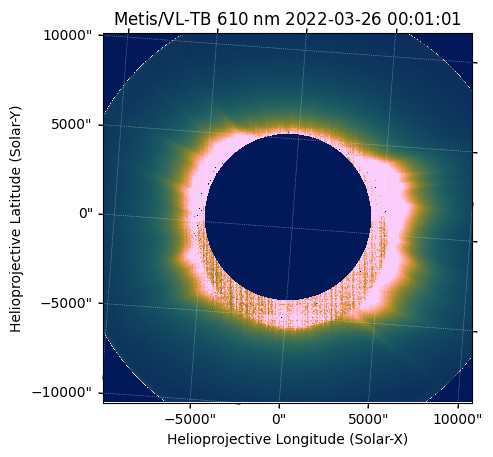

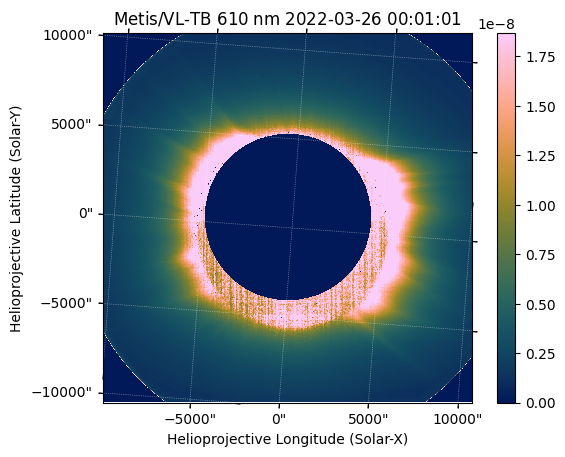

In [ ]:
# ------------------------------------------------------------
# Load a Metis Level-2 map
# ------------------------------------------------------------

i = 0          # Index of the file in 'downloaded_files' (0 = first file)
extension = 0  # FITS extension: 0=science, 1=quality, 2=error/uncertainty

import warnings
from sunpy.util.exceptions import SunpyMetadataWarning

warnings.filterwarnings(
    "ignore",
    category=SunpyMetadataWarning,
    message=r'.*unit string "MSB".*'
)
# Create a SunPy Map from the selected Metis FITS file
# then select the desired extension

file2map = sunpy.map.Map(downloaded_files[i])
Metis_map = file2map[extension]

# ------------------------------------------------------------
# Quicklook visualization of the Metis map
# ------------------------------------------------------------
# SunPy automatically handles:
# - World Coordinate System (WCS)
# - Axis labels and units
# - Image orientation and title
Metis_map.plot()

# Optional: interactive preview (opens a figure with metadata info)
Metis_map.peek()

 ### **Inspect Metis FITS metadata**
Each SunPy map carries a metadata dictionary (`.meta`) derived from the FITS header.
 This includes observational, instrumental, and calibration information and is useful to
 quickly check (for example):
   - observation time and processing level
   - observing mode / product type / wavelength band
   - exposure and cadence keywords
   - WCS, pointing and roll/orientation
   - geometry (Sun–spacecraft distance, apparent solar radius)
   - pipeline provenance (software/calibration versions)

 For the full keyword definitions, refer to the Metis Data Product Description Document (DPDD).


In [ ]:
# ------------------------------------------------------------
# Inspect Metis FITS metadata
# ------------------------------------------------------------
print(Metis_map.meta)

**Quick-look metadata panel**

Metis L2 FITS headers contain many keywords, and printing the full header is often too verbose.
The cell below prints a compact **quick-look panel** by selecting and grouping the most useful keywords by topic (timing, observing mode, exposure, radiometry, WCS/pointing, geometry, provenance).

In [ ]:
# ------------------------------------------------------------
# Highlight key Metis FITS keywords (quick-look panel)
# ------------------------------------------------------------

from textwrap import shorten

meta = Metis_map.meta

# Group keywords by analysis concept
KEYWORDS = {
    "Observation timing": [
        "date-obs", "date-beg", "date-avg", "date-end", "timesys"
    ],
    "Instrument / observing mode": [
        "obsrvtry", "telescop", "instrume", "detector",
        "obs_mode", "obs_type", "soopname", "sooptype", "obs_id",
        "filter", "waveband", "wavelnth", "wavemin", "wavemax"
    ],
    "Exposure / cadence": [
        "xposure", "dit", "ndit", "nsumexp", "cadence", "telapse"
    ],
    "Radiometry / science quantity": [
        "btype", "bunit", "datamin", "datamax", "comment"
    ],
    "WCS / pointing": [
        "wcsname", "ctype1", "ctype2", "cunit1", "cunit2",
        "cdelt1", "cdelt2", "crota", "pc1_1", "pc1_2", "pc2_1", "pc2_2",
        "crpix1", "crpix2", "crval1", "crval2"
    ],
    "Geometry / solar ephemeris": [
        "sun_xcen", "sun_ycen", "rsun_arc", "solar_b0", "solar_p0",
        "hglt_obs", "hgln_obs", "crlt_obs", "crln_obs",
        "dsun_au", "dsun_obs"
    ],
    "Pipeline provenance": [
        "level", "creator", "vers_sw", "vers_cal", "date", "history"
    ]
}

def _get(meta, k):
    # SunPy meta is case-insensitive-ish, but safest is direct get
    return meta.get(k, "—")

def print_panel(meta, groups=KEYWORDS, max_width=90):
    for title, keys in groups.items():
        print(f"\n=== {title} ===")
        for k in keys:
            v = _get(meta, k)
            # make long strings readable
            if isinstance(v, str) and len(v) > max_width:
                v = shorten(v, width=max_width, placeholder=" …")
            print(f"{k:>10s} : {v}")

print_panel(meta)

# ------------------------------------------------------------
# A few "interpretation" helpers (optional)
# ------------------------------------------------------------
print("\n--- Derived / quick interpretation ---")

# Total effective exposure time (already in XPOSURE, but we restate)
xposure = float(meta.get("xposure", "nan"))
ndit = float(meta.get("ndit", "nan"))
dit_ms = float(meta.get("dit", "nan"))
dsun_au = float(meta.get("dsun_au", "nan"))
cdelt1 = float(meta.get("cdelt1", "nan"))

print(f"Total effective exposure (XPOSURE): {xposure:.1f} s")
print(f"Detector integration time (DIT): {dit_ms:.0f} ms, averaged frames (NDIT): {ndit:.0f}")
print(f"Spacecraft–Sun distance (DSUN_AU): {dsun_au:.3f} AU")
print(f"Pixel scale (CDELT1): {cdelt1:.3f} arcsec/pix")



=== Observation timing ===
  date-obs : 2022-03-26T00:01:01.256
  date-beg : 2022-03-26T00:01:01.256
  date-avg : 2022-03-26T00:10:42.268
  date-end : 2022-03-26T00:20:23.281
   timesys : UTC

=== Instrument / observing mode ===
  obsrvtry : Solar Orbiter
  telescop : SOLO/Metis/VLD
  instrume : Metis
  detector : VLD
  obs_mode : METIS_MAGTOP
  obs_type : bf9Y
  soopname : L_BOTH_HRES_LCAD_CH-Boundary-Expansion
  sooptype : LB1
    obs_id : SMET_060A_LB1_111_bf9Y_112
    filter : VL
  waveband : Visible light
  wavelnth : 610.0
   wavemin : 580.0
   wavemax : 640.0

=== Exposure / cadence ===
   xposure : 280.0
       dit : 20000
      ndit : 14
   nsumexp : 14
   cadence : 1200000
   telapse : 1162.02342224

=== Radiometry / science quantity ===
     btype : VL total brightness
     bunit : MSB
   datamin : -1.96267749011e-06
   datamax : 1.16895081034e-05
   comment : Image values were corrected for the total exposure time. Uncertainty matrix in the FITS …

=== WCS / pointing ===
 

**Understanding a few key Metis FITS keywords**

Metis L2 headers include many FITS keywords. For this tutorial we only highlight the few that are most useful for quicklook plotting and multi-instrument alignment (full definitions are available in the Metis DPDD).

**Exposure:** `XPOSURE` is the total effective exposure time of the L2 product (already accounting for frame summing and detector integration time).

**Physical quantity:** `BTYPE` and `BUNIT` describe what the image contains and its units (e.g., VL brightness products are often expressed in MSB, Mean Solar Brightness).

**WCS/pointing :**
`CTYPE*`, `CDELT*`, `CRPIX*`, and `CRVAL*` describe the helioprojective axes in arcseconds,
while `CROTA` and the `PCi_j` matrix encode the image rotation. These keywords enable overlays and reprojection with other instruments.

**Geometry:**
`DSUN_AU` (Sun-spacecraft distance in AU) and `RSUN_ARC` (apparent solar radius in arcseconds) are essential to convert pixel into physical scales or solar-radii.

## **Refine the Metis visualization**

Coronagraph images span a very large dynamic range and include regions that are not physically meaningful (e.g. the internal/external occulters). Before moving to quantitative analysis or multi-instrument overlays, it is useful to apply a few standard “quicklook” refinements:

 to hide

1.   **Mask the occulters** to hide pixels inside the occulting disks.

2. **Add context overlays** (solar limb and heliographic grid) to better interpret orientation and field of view.

3. **Improve contrast** with a robust normalisation/stretch to reveal faint coronal structures while reducing the impact of outliers.







solar orbitermetisvl-tb


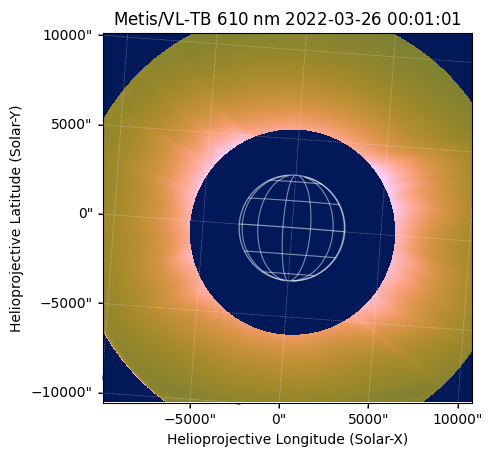

In [ ]:

from astropy.visualization import ImageNormalize, PowerStretch
import numpy as np

# ------------------------------------------------------------
# 1. Mask the occulters
# ------------------------------------------------------------
# Hide pixels in the internal/external occulter regions where mask_val = 0.
# (These pixels are not physically meaningful for coronal interpretation.)
Metis_map.mask_occs(mask_val=0)

# ------------------------------------------------------------
# 2. Add contextual overlays: solar limb + heliographic grid
# ------------------------------------------------------------
# The limb and heliographic grid provide spatial context and help interpret
# the map orientation and observing geometry.
Metis_map.draw_limb(color = 'white', alpha = 0.5)
Metis_map.draw_grid(color = 'white', alpha = 0.5, grid_spacing = 30*u.deg)

# ------------------------------------------------------------
# 3. Enhance visibility with a custom display scaling
# ------------------------------------------------------------
# METISMap.plot() may apply internal percentile clipping via `contr_cut`.
# Here we disable that and define an custo normalisation (`norm`):
# - vmin = 0  (typical for brightness-like products)
# - vmax = 99.9% to reduce the impact of a few very bright pixels (outliers)
# - PowerStretch = 0.2 to enhance faint coronal structures without saturating the brightest regions
Metis_map.contr_cut = None

Metis_map.plot_settings["norm"] = ImageNormalize(
    vmin=0,
    vmax=np.nanpercentile(Metis_map.data, 99.9),
    stretch=PowerStretch(0.2)
)

# Remove any legacy vmin/vmax settings to avoid conflicts
# if vmin/vmax were previously stored in plot_settings
Metis_map.plot_settings.pop("vmin", None)
Metis_map.plot_settings.pop("vmax", None)
# Plot refined quicklook
Metis_map.plot()





## **Map Rotation**

For comparisons across instruments (e.g. Metis vs EUI) it is often helpful to work in a consistent orientation.
SunPy’s `rotate()` returns a **new map with an updated WCS**, typically rotating the image so that **solar north is up** (or to a user-defined angle).

For additional options (e.g. interpolation settings, padding/cropping, rotation metadata), see the [SunPy documentation](https://docs.sunpy.org/en/stable/generated/gallery/map/map_rotation.html) on map rotation.


solar orbitermetisvl-tb


<CoordinatesMap with 2 world coordinates:

  index aliases    type   unit    wrap   format_unit visible
  ----- ------- --------- ---- --------- ----------- -------
      0     lon longitude  deg 180.0 deg         deg     yes
      1     lat  latitude  deg      None         deg     yes

>

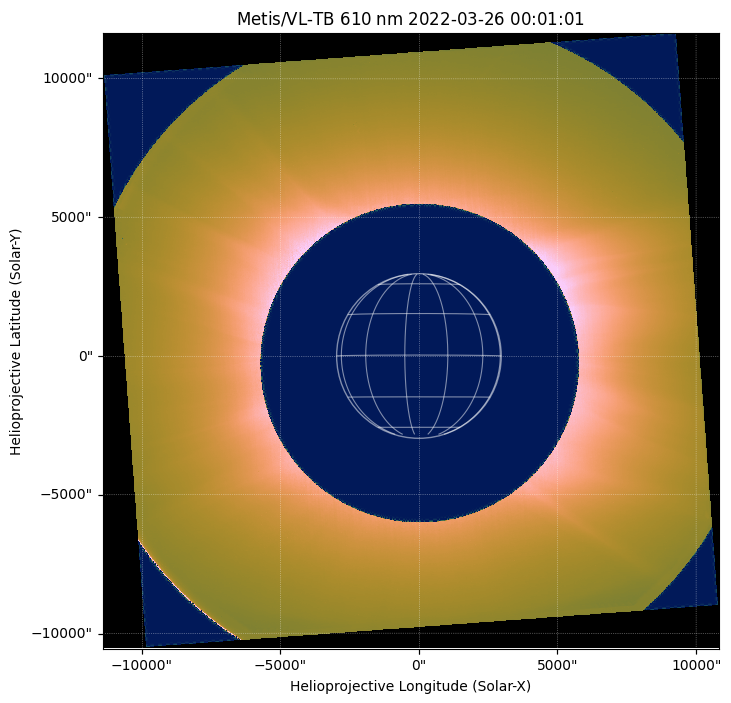

In [ ]:
# ------------------------------------------------------------
# Rotate the Metis map
# ------------------------------------------------------------
# By default, SunPy rotates the map so that solar north is up.
# You can also specify a custom angle, e.g. `rotate(angle=30*u.deg)`.
Metis_map_rotated = Metis_map.rotate()

# ------------------------------------------------------------
# Plot the rotated map
# ------------------------------------------------------------
# The image is now displayed with the rotated WCS, enabling consistent
# comparison with other instruments/maps.
plt.figure(figsize=(8, 8))

# Apply the same display scaling used above
Metis_map_rotated.contr_cut = None
Metis_map_rotated.plot_settings["norm"] = ImageNormalize(
    vmin=0,
    vmax=np.nanpercentile(Metis_map_rotated.data, 99.9),
    stretch=PowerStretch(0.2)
)

Metis_map_rotated.plot_settings.pop("vmin", None)
Metis_map_rotated.plot_settings.pop("vmax", None)

Metis_map_rotated.plot()


# Optional: add contextual overlays (solar limb + heliographic grid)
Metis_map_rotated.draw_limb(color="white", alpha=0.5)
Metis_map_rotated.draw_grid(color="white", alpha=0.5, grid_spacing=30*u.deg)


## Download EUI/FSI Data for Joint Metis–EUI Analysis

Combining disk and coronagraph observations provides a continuous view from the low corona to severla solar radii. Here we use **EUI/FSI 174 Å** as the disk imager to capture the disk and low corona, and  **Metis VL ** to trace the outer corona.

There are several eays to overlay disk and coronagraph data. In this example we follow a **Spherical Screen** approach, following the logic of a SunPy overlay tutorials (e.g., [AIA & LASCO-C2 overlay](https://docs.sunpy.org/en/stable/generated/gallery/plotting/lasco_overlay.html)) and adapting it to build a **Metis–EUI composite**.

As a first step, we query **EUI Full Sun Imager (FSI) 174 Å Level 2** observation from SOAR over the same time range used for Metis. We then select the file **closest in time** to the Metis observation (recommended for reproducibility), download it, and proceed with reprojection.

In [ ]:
from sunpy.net import Fido, attrs as a

# ------------------------------------------------------------
# Query EUI/FSI 174 Å (Level 2) data from SOAR
# ------------------------------------------------------------

# Select the Solar Orbiter instrument EUI
instrument = a.Instrument("EUI")
# Select the EUI product: FSI 174 Å Level-2 image
product = a.soar.Product("EUI-FSI174-IMAGE")
# Define the data processing level
level = a.Level(2)

eui_result = Fido.search(instrument & time & product & level)

n_files = len(eui_result[0])
print(f"Found {n_files} matching EUI/FSI files.")

if n_files == 0:
    raise ValueError("No EUI/FSI files found in the selected time range. Try expanding `time`.")

display(eui_result)



Found 6 matching EUI/FSI files.


Instrument,Data product,Level,Start time,End time,Data item ID,Filename,Filesize,SOOP Name,Detector,Wavelength
,,,,,,,Mbyte,,,
str3,str16,str2,str23,str23,str43,str52,float64,str38,str3,float64
EUI,eui-fsi174-image,L2,2022-03-26 00:08:45.212,2022-03-26 00:08:55.212,solo_L2_eui-fsi174-image_20220326T000845212,solo_L2_eui-fsi174-image_20220326T000845212_V02.fits,5.763,L_BOTH_HRES_LCAD_CH-Boundary-Expansion,FSI,174.0
EUI,eui-fsi174-image,L2,2022-03-26 00:18:45.213,2022-03-26 00:18:55.213,solo_L2_eui-fsi174-image_20220326T001845213,solo_L2_eui-fsi174-image_20220326T001845213_V02.fits,5.789,L_BOTH_HRES_LCAD_CH-Boundary-Expansion,FSI,174.0
EUI,eui-fsi174-image,L2,2022-03-26 00:28:45.215,2022-03-26 00:28:55.215,solo_L2_eui-fsi174-image_20220326T002845215,solo_L2_eui-fsi174-image_20220326T002845215_V02.fits,5.766,L_BOTH_HRES_LCAD_CH-Boundary-Expansion,FSI,174.0
EUI,eui-fsi174-image,L2,2022-03-26 00:38:45.216,2022-03-26 00:38:55.216,solo_L2_eui-fsi174-image_20220326T003845216,solo_L2_eui-fsi174-image_20220326T003845216_V02.fits,5.769,L_BOTH_HRES_LCAD_CH-Boundary-Expansion,FSI,174.0
EUI,eui-fsi174-image,L2,2022-03-26 00:48:45.217,2022-03-26 00:48:55.217,solo_L2_eui-fsi174-image_20220326T004845217,solo_L2_eui-fsi174-image_20220326T004845217_V02.fits,5.751,L_BOTH_HRES_LCAD_CH-Boundary-Expansion,FSI,174.0
EUI,eui-fsi174-image,L2,2022-03-26 00:58:45.218,2022-03-26 00:58:55.218,solo_L2_eui-fsi174-image_20220326T005845218,solo_L2_eui-fsi174-image_20220326T005845218_V02.fits,5.769,L_BOTH_HRES_LCAD_CH-Boundary-Expansion,FSI,174.0


**Select the closest-in-time EUI file (recommended)**

In [ ]:
from astropy.time import Time
import numpy as np

# Metis observation time (use DATE-OBS if available)
t_metis = Time(Metis_map.date)

# Extract EUI start times from the query table
t_eui = Time(eui_result[0]["Start time"])

# Find closest file
idx = np.argmin(np.abs(t_eui - t_metis))
print(f"Closest EUI file index: {idx}")
print(f"Metis time: {t_metis.isot}")
print(f"EUI time : {t_eui[idx].isot}  (Δt = {(t_eui[idx]-t_metis).to('min').value:.1f} min)")

# Download the selected file
downloaded_files_EUI = Fido.fetch(eui_result[0][idx])
print(f"Downloaded file: {downloaded_files_EUI[0]}")


Closest EUI file index: 0
Metis time: 2022-03-26T00:01:01.256
EUI time : 2022-03-26T00:08:45.212  (Δt = 7.7 min)


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

solo_L2_eui-fsi174-image_20220326T000845212_V02.fits:   0%|          | 0.00/5.76M [00:00<?, ?B/s]

Downloaded file: /root/sunpy/data/solo_L2_eui-fsi174-image_20220326T000845212_V02.fits


In [ ]:
# ------------------------------------------------------------
# Download
# ------------------------------------------------------------
# For simplicity we download the first match.
# (Optionally: select the closest-in-time file if you have a target timestamp.)
downloaded_files_EUI = Fido.fetch(result[0][0])
print(f"Downloaded file: {downloaded_files_EUI[0]}")



**Reproject EUI onto the Metis frame**

To build a composite, both datasets must share a common coordinate frame and WCS projection. Even though both instruments observe from Solar Orbiter, they differ in optical geometry, plate scale, and sampling. We therefore **reproject the EUI map onto a target helioprojective WCS** constructed using:

- the **Metis observer** and **observation time** (consistent viewpoint),

- the **EUI pixel scale** (preserve disk sampling),

a spherical-screen assumption to map both datasets onto a common surface.

To display EUI and Metis data in a single composite view, both maps must share the same coordinate frame and WCS projection. Although both instruments observe from Solar Orbiter, they differ in optical geometry, plate scale, and pixel sampling. For this reason, we reproject the **EUI map onto the Metis WCS**.




In [ ]:
from sunpy.coordinates import SphericalScreen
from astropy.coordinates import SkyCoord
import astropy.units as u

# ------------------------------------------------------------
# Load EUI as a SunPy Map
# ------------------------------------------------------------
EUI_map = sunpy.map.Map(downloaded_files_EUI[i])

# ------------------------------------------------------------
# Target coordinate definition (Metis observer/time, centered on Sun)
# ------------------------------------------------------------
projected_coord = SkyCoord(
    0 * u.arcsec, 0 * u.arcsec,
    obstime=Metis_map.observer_coordinate.obstime,
    frame="helioprojective",
    observer=Metis_map.observer_coordinate,
    rsun=EUI_map.coordinate_frame.rsun,
)

# Build a WCS header describing the target grid.
# Note: we keep the EUI sampling keep EUI sampling (disk resolution), but Metis viewpoint/time
projected_header = sunpy.map.make_fitswcs_header(
    EUI_map.data.shape,
    projected_coord,
    scale=u.Quantity(EUI_map.scale),
    instrument=EUI_map.instrument,
    wavelength=EUI_map.wavelength,
)

# ------------------------------------------------------------
# Reproject EUI onto the target WCS using a spherical screen
# ------------------------------------------------------------
# The SphericalScreen context ensures that the reprojection is performed
# consistently onto a common helioprojective surface (disk-like screen).
with SphericalScreen(EUI_map.observer_coordinate):
    EUI_map_reprojected = EUI_map.reproject_to(projected_header)

## **Build a Metis–EUI composite image**

We plot the reprojected **EUI/FSI 174 Å** map as the background and overlay the **Metis VL** map on top. A clean composite relies on:

- **Drawing order** (`zorder`): EUI first (background), Metis on top.
> `zorder` controls which layer is drawn first: `zorder = 0` → plotted first (background);  `zorder = 1` → plotted on top


- **Transparent NaNs in Metis**: Metis pixels masked as `NaN` (e.g. occulter region or out-of-FOV) will be displayed as transparent, so the EUI background remains visible where Metis has no valid data.

- **Independent contrast scaling**: EUI and Metis have very different intensity distributions, so we apply **separate normalization/contrast stretches** to each map to optimise visibility of both disk and coronal structures.









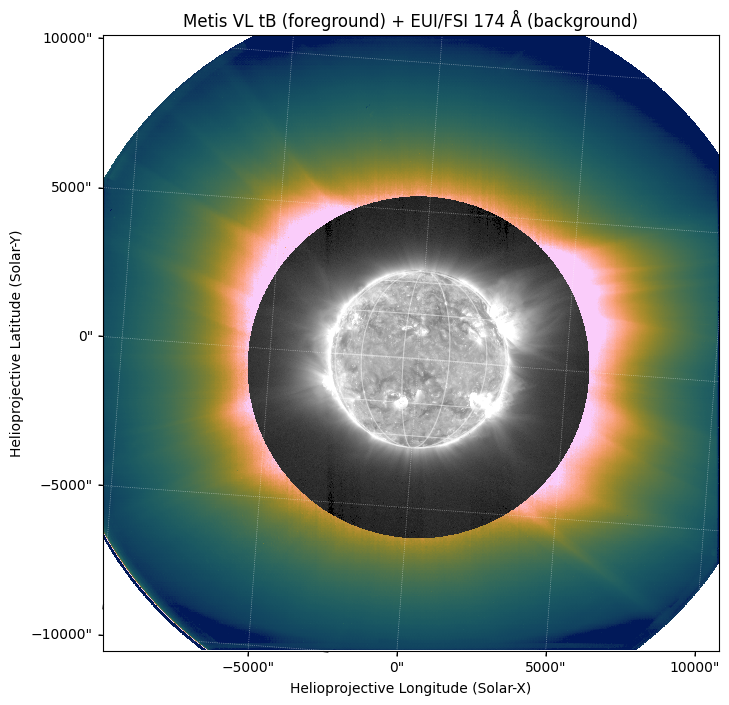

In [ ]:
# ------------------------------------------------------------
# Composite plot: EUI/FSI 174 Å (background) + Metis VL (foreground)
# ------------------------------------------------------------
# We draw both maps on the same WCS axes (Metis frame). The EUI map has already
# been reprojected to the target WCS, so it can be overlaid directly.

from sunpy.map import GenericMap


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection=Metis_map)

# ------------------------------------------------------------
# Set independent display scaling for the two datasets
# ------------------------------------------------------------
# EUI and Metis have very different intensity distributions. We therefore apply
# separate normalizations (percentile limits + PowerStretch) to optimise visibility.

# --- EUI background (own normalisation)
eui_norm = ImageNormalize(
    vmin=np.nanpercentile(EUI_map_reprojected.data, 5),
    vmax=np.nanpercentile(EUI_map_reprojected.data, 99),
    stretch=PowerStretch(0.22),
)

ax.imshow(
    EUI_map_reprojected.data,
    origin="lower",
    norm=eui_norm,
    cmap="gray",
    transform=ax.get_transform(EUI_map_reprojected.wcs),
    zorder=0,
)

# --- Metis foreground: mask occulters as NaN for transparency
Metis_map.mask_occs(mask_val=np.nan)

# Copy the colormap to avoid modifying it globally, then set NaNs to transparent.
metis_cmap = Metis_map.plot_settings["cmap"].copy()
metis_cmap.set_bad(color=(0, 0, 0, 0))  # NaN transparent
Metis_map.plot_settings["cmap"] = metis_cmap

metis_norm = ImageNormalize(
    vmin=np.nanpercentile(Metis_map.data, 5),
    vmax=np.nanpercentile(Metis_map.data, 98),
    stretch=PowerStretch(0.5),
)
Metis_map.plot_settings["norm"] = metis_norm

# Use GenericMap.plot to avoid METISMap.plot() overriding cmap
GenericMap.plot(Metis_map, axes=ax, zorder=1)

Metis_map.draw_limb(color="white", alpha=0.5)
Metis_map.draw_grid(color="white", alpha=0.5, grid_spacing=30*u.deg)
ax.set_title("Metis VL tB (foreground) + EUI/FSI 174 Å (background)")
plt.show()



> Note: for slowly evolving coronal structures, a ∼7-minute time offset between the EUI and Metis observations is usually negligible; for rapidly evolving transient events, however, such a delay may be significant and a closer time match is recommended.



---